## Setup and Data Import

In [1]:
import numpy as np

import pandas as pd
pd.options.display.max_rows = None
pd.options.display.max_columns = None

import sys
sys.path.insert(0,'..')

import Imputation_Module as imp
import FeatureEngineering_Module as fe
import Encoding_Module as ec

from sklearn.metrics import mean_squared_error, mean_squared_log_error
import sklearn.linear_model as lm
import sklearn.model_selection as ms
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor

# import statsmodels.api as sm

import random

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_raw = pd.read_csv('../train.csv')
test_raw = pd.read_csv('../test.csv')

train = train_raw.copy()
test = test_raw.copy()

## Imputation and Feature Engineering

In [3]:
train, test = imp.impute_data()

train = fe.FeatureEngineering(train)
test = fe.FeatureEngineering(test)

train_dummies, test_dummies = fe.Dummify(train, test)

train_ec, test_ec = ec.encode(train, test)

In [4]:
X = train_dummies.drop('SalePrice', 1)
y = train_dummies.SalePrice

In [5]:
X_ec = train_ec.drop('SalePrice', 1)
y_ec = train_dummies.SalePrice

## Modeling

### Linear Modeling

In [6]:
def linear_model(model, X=X, y=y):
    model.fit(X, y)
    model_scores = model.score(X, y)
    y_pred = model.predict(X)
    RMSE = mean_squared_error(y, y_pred, squared=False)
    print('%s R^2: %0.5f'
          % (type(model).__name__, model_scores.mean()))
    print('Root Mean Squared Error: %0.5f' % RMSE)
# What is the difference between RMSE and RMSLE?
# What is the difference between cv=5 and cv=10?

#### Baseline

In [7]:
ols = lm.LinearRegression()
linear_model(ols)

LinearRegression R^2: 0.92861
Root Mean Squared Error: 20485.11719


In [8]:
# Improves satisfaction of linearity assumption
log_y = np.log(y)

#### Log(y)

In [9]:
linear_model(ols, y=log_y)

LinearRegression R^2: 0.93162
Root Mean Squared Error: 0.10354


In [10]:
# Top Feature Importances from GB tree
linear_model(ols,
             X=X_ec[['OverallQual', 'GrLivArea', 'GarageCars', 'KitchenQual',
                     'ExterQual','LotArea', 'GarageType', 'SinceRemod',
                     'BsmtQual', 'FullBaths', 'BsmtFinType1']],
             y=log_y)

LinearRegression R^2: 0.85172
Root Mean Squared Error: 0.15246


#### Ridge

In [11]:
ridgecv = lm.RidgeCV(alphas=np.logspace(-5, 5, 100), normalize=True)
linear_model(ridgecv, y=log_y)
# Why does Ridge use LOOCV by default instead of k-fold?

RidgeCV R^2: 0.93081
Root Mean Squared Error: 0.10415


In [12]:
# Top Feature Importances from GB tree
linear_model(ridgecv,
             X=X_ec[['OverallQual', 'GrLivArea', 'GarageCars', 'KitchenQual',
                     'ExterQual','LotArea', 'GarageType', 'SinceRemod',
                     'BsmtQual', 'FullBaths', 'BsmtFinType1']],
             y=log_y)

RidgeCV R^2: 0.85165
Root Mean Squared Error: 0.15251


#### Lasso

In [13]:
lasso = lm.LassoCV(normalize=True)
linear_model(lasso, y=log_y)
# Why does Ridge specify alphas but Lasso sets them automatically?

LassoCV R^2: 0.92792
Root Mean Squared Error: 0.10630


In [14]:
# Top Feature Importances from GB tree
linear_model(lasso,
             X=X_ec[['OverallQual', 'GrLivArea', 'GarageCars', 'KitchenQual',
                     'ExterQual','LotArea', 'GarageType', 'SinceRemod',
                     'BsmtQual', 'FullBaths', 'BsmtFinType1']],
             y=log_y)

LassoCV R^2: 0.85159
Root Mean Squared Error: 0.15254


#### Elastic Net

In [15]:
net = lm.ElasticNetCV(normalize=True)
linear_model(net, y=log_y)
# When would we choose Elastic Net?

ElasticNetCV R^2: 0.92802
Root Mean Squared Error: 0.10623


In [16]:
# Top Feature Importances from GB tree
linear_model(net,
             X=X_ec[['OverallQual', 'GrLivArea', 'GarageCars', 'KitchenQual',
                     'ExterQual','LotArea', 'GarageType', 'SinceRemod',
                     'BsmtQual', 'FullBaths', 'BsmtFinType1']],
             y=log_y)

ElasticNetCV R^2: 0.85169
Root Mean Squared Error: 0.15248


#### PCA

In [17]:
# Because PCA results were worse, does that mean the manual feature selection done was effective?

In [18]:
# pca = PCA()
# pca_pipe = Pipeline(steps=[('pca', pca), ('lasso', lasso)])

# pca_params = {'pca__n_components': np.arange(5, 55, 5)}
# pca_search = ms.GridSearchCV(pca_pipe, pca_params)
# pca_search.fit(X, log_y)

# linear_model(pca_search, y=log_y)
# -------------------------------------------------------------
# TAKES FOREVER TO RUN. RESULTS:

# Ridge Cross-Validation Accuracy: 0.87426 (+/- 0.02962)
# Root Mean Squared Error: 0.13987

# Lasso Cross-Validation Accuracy: 0.87360 (+/- 0.02834)
# Root Mean Squared Error: 0.14004

In [19]:
# From here, what explains the remaining errors? It looks like from Ryan's charts,
# it was variance.

### Tree Modeling

In [20]:
X_train, X_test, y_train, y_test = ms.train_test_split(X_ec, y_ec, test_size=0.2, random_state=0)

In [21]:
def get_error(X_train, y_train, X_test, y_test, model, show = True):
    model.fit(X_train, y_train)
    train_error = 1 - model.score(X_train, y_train)
    test_error  = 1 - model.score(X_test, y_test)
    if show:
        print("The training error is: %.5f" %train_error)
        print("The test     error is: %.5f" %test_error)
    return [train_error, test_error]

#### Baseline

In [22]:
tree_model = tree.DecisionTreeRegressor()
get_error(X_train, y_train, X_test, y_test, tree_model);

The training error is: 0.00000
The test     error is: 0.24913


#### Log(y) - not useful for decision trees because DTs have no linearity assumption

In [23]:
tree_model = tree.DecisionTreeRegressor()
get_error(X_train, y_train.apply(np.log), X_test, y_test.apply(np.log),
          tree_model);

The training error is: 0.00000
The test     error is: 0.24512


In [24]:
grid_para_tree = {'criterion': ["mse", "friedman_mse", "mae"],
                  'max_depth': range(1, 31)}
grid_search_tree = ms.GridSearchCV(tree_model, grid_para_tree, cv=10)

get_error(X_train, y_train, X_test, y_test, grid_search_tree)
print('The best score is %.4f' %grid_search_tree.best_score_)
grid_search_tree.best_params_

The training error is: 0.14420
The test     error is: 0.23300
The best score is 0.7258


{'criterion': 'friedman_mse', 'max_depth': 5}

#### Gradient Boosting

In [25]:
# gb_model = GradientBoostingRegressor()

# grid_para_gb = {'loss': ['ls', 'lad', 'huber', 'quantile'],
#                 'criterion': ["mse", "friedman_mse", "mae"],
#                 'max_depth': range(1, 10)}
# grid_search_gb = ms.GridSearchCV(gb_model, grid_para_gb, cv=5)

# get_error(X_train, y_train, X_test, y_test, grid_search_gb)
# print('The best score is %.4f' %grid_search_gb.best_score_)
# print('The best parameters are:', grid_search_gb.best_params_)

# # -------------------------------------------------------------
# # TAKES FOREVER TO RUN. RESULTS:

# # The best parameters are: {'criterion': 'friedman_mse', 'loss': 'huber', 'max_depth': 4}

In [26]:
gb_model = GradientBoostingRegressor(loss='huber', n_estimators=200, max_depth=4)
get_error(X_train, y_train.apply(np.log), X_test, y_test.apply(np.log),
          gb_model);

The training error is: 0.01811
The test     error is: 0.07884


<BarContainer object of 49 artists>

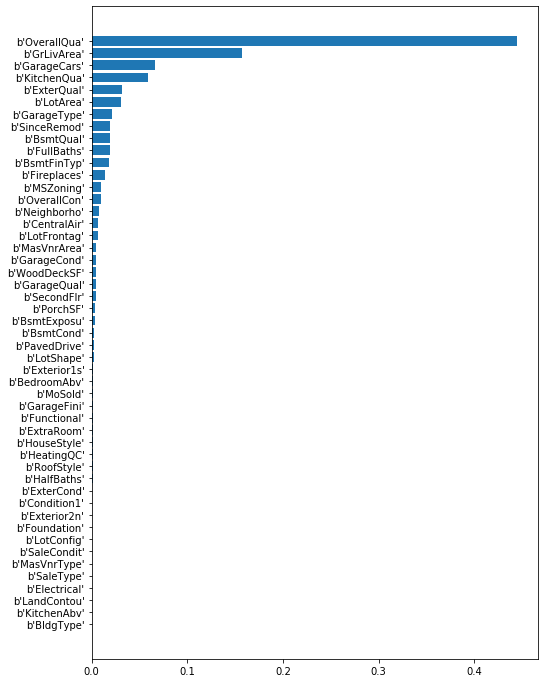

In [27]:
feature_importance = list(zip(X_train.columns, gb_model.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype = dtype)
feature_sort = np.sort(feature_importance, order='importance')
featureNames, featureScores = zip(*list(feature_sort))

from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 12), facecolor='w')
plt.barh(range(len(featureScores)), featureScores, tick_label=featureNames)